# Predict energy demand in Australia

In [12]:
import os
import glob
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.inspection import permutation_importance

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from scipy.stats import pearsonr, randint, uniform
from scipy.spatial.distance import correlation

import matplotlib.pyplot as plt

### Note:

You will need to change the kernel to ml_env to use `mlxtend`

In [1]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

In [4]:
region = "SA"

### Demand

In [5]:
# demand = pd.read_csv(
#     "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020.csv",
#     index_col=0,
#     parse_dates=True
# )

In [6]:
# demand = demand.sum(axis=1)

In [7]:
# demand.plot()

In [8]:
# dem_da = xr.DataArray(
#     demand.squeeze(),
#     dims=["time"],
#     coords={"time": demand.index.values}
# )

In [9]:
# dem_da = dem_da.expand_dims({"region": [region]})

In [10]:
# dem_da = fn.detrend_dim(dem_da, "time") + dem_da.mean("time")

In [13]:
dem_da = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020_stl.nc"
)["demand_stl"]

In [14]:
dem_da = dem_da.sel(region=region).expand_dims({"region": [region]})

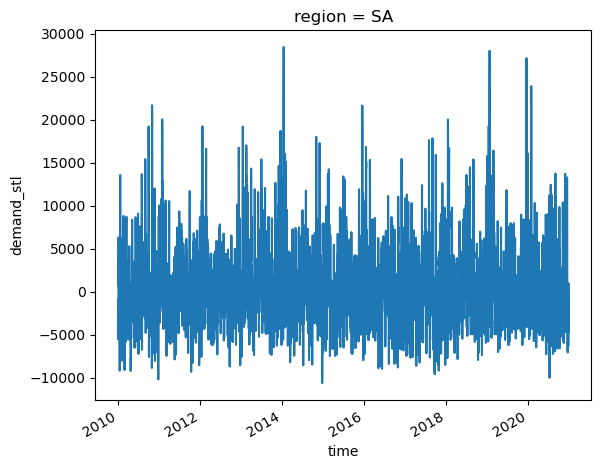

In [15]:
dem_da.plot()

### Predictors

In [32]:
files = fn.get_predictor_files("NEM", "pop_discrete_100_mask")

In [33]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override")

In [34]:
pred_ds = pred_ds.sel(region=region).expand_dims({"region": [region]}).compute()

In [35]:
pred_ds.data_vars

Data variables:
    q         (region, time) float64 6.599 6.354 6.476 ... 7.033 8.043 8.751
    t2m4      (region, time) float64 nan nan nan 297.6 ... 297.2 294.9 293.9
    t2m       (region, time) float64 293.6 295.5 300.4 ... 292.1 294.5 298.2
    t2m3      (region, time) float64 nan nan 296.5 298.9 ... 295.1 292.4 294.9
    hdd4      (region, time) float64 nan nan nan 0.1635 ... 0.4967 0.5244 0.5283
    hdd3      (region, time) float64 nan nan 0.2118 ... 0.6685 0.7055 0.2243
    rh        (region, time) float64 46.46 39.94 29.44 ... 51.18 51.62 45.91
    cdd       (region, time) float64 0.8466 1.075 3.423 ... 0.1873 0.6364 2.149
    w10       (region, time) float64 5.187 3.6 2.469 2.7 ... 4.239 3.83 2.719
    t2min     (region, time) float64 nan 289.3 294.6 294.3 ... 287.1 288.8 292.2
    t2max     (region, time) float64 nan 301.9 306.3 308.3 ... 297.4 300.3 304.5
    msdwswrf  (region, time) float64 365.9 379.5 367.8 ... 347.3 362.0 372.5
    mtpr      (region, time) float64 1.216

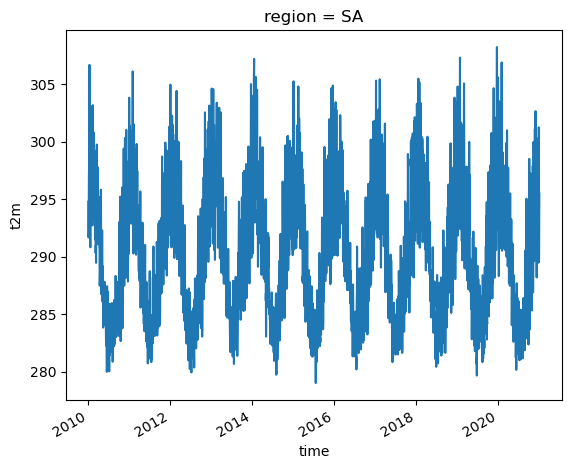

In [36]:
pred_ds.t2m.sel(time=slice("2010", "2020")).plot()

## Prepare data

In [37]:
# time_cols = ["is_weekend", "month_sin", "month_cos"]
# time_cols = ["is_weekend", "month_int"]
# time_cols = ["is_weekend", "season_int"]
# time_cols = ["is_weekend", "is_transition"]
time_cols = ["is_weekend"]
# time_cols = []

region_dfs = {}
for region in dem_da.region.values:
    df = fn.to_dataframe(dem_da, pred_ds, region)
    for t in time_cols:
        df = fn.add_time_column(df, t)
    new_cols = np.append(np.append("demand", time_cols), df.columns[:-(len(time_cols) + 1)])
    df = df[new_cols]
    region_dfs[region] = df

In [38]:
# region_dfs[region]["year"] = region_dfs[region].index.year

In [39]:
region_dfs[region]

,demand,is_weekend,q,t2m4,t2m,t2m3,hdd4,hdd3,rh,cdd,w10,t2min,t2max,msdwswrf,mtpr,hdd,cdd3,cdd4
2010-01-01,-5472.341578,0,8.545424,299.805176,294.798686,299.647174,0.010846,0.017792,52.932292,0.770967,5.083113,288.479871,304.029629,349.269702,4.714016e-06,0.075711,3.702972,3.642639
2010-01-02,-942.669393,1,6.498830,297.657412,291.688480,295.290162,0.157575,0.213812,49.619873,0.122731,5.278260,286.690265,297.412885,341.838323,1.253218e-07,0.576921,1.210443,2.807866
2010-01-03,-3067.599531,1,6.437700,294.572070,292.418152,292.968647,0.294650,0.396572,47.835546,0.200537,3.155486,286.896829,298.170755,369.187339,-5.579563e-08,0.537160,0.364800,0.957921
2010-01-04,-2422.636892,0,6.356869,293.714131,295.950943,293.352732,0.311409,0.389974,38.250943,0.674859,1.823904,288.439670,303.229501,382.836240,-5.805932e-08,0.055919,0.332764,0.442270
2010-01-05,-3082.916386,0,6.562966,294.231144,296.866739,295.078819,0.319737,0.234008,38.213168,1.567024,3.451809,289.704450,304.371078,377.559265,9.827563e-08,0.109024,0.814195,0.641284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,958.344515,1,5.836895,295.099946,301.266207,296.300149,0.412077,0.312612,25.110155,4.259964,1.837036,294.804518,307.208016,367.015499,8.596113e-08,-0.017584,1.729504,1.299856
2020-12-27,-3081.253599,1,6.288104,295.023221,291.193008,295.862040,0.667514,0.641217,50.086989,0.559245,5.419239,284.881206,302.760756,263.951535,3.056671e-06,1.732217,1.838909,1.436868
2020-12-28,-4788.516196,0,5.331962,294.289767,289.573519,294.011238,1.030878,1.304789,46.740850,0.057891,4.565552,284.776020,294.726018,335.398312,1.709216e-07,2.199857,1.625787,1.393583
2020-12-29,-4331.918628,0,7.181144,293.616274,292.431950,291.066487,1.052864,1.409678,53.295910,0.105338,3.954949,287.614967,298.171104,353.613872,1.676277e-07,0.297083,0.240912,1.245603


## Split data into training and testing

Using this as a guide: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

As this is time series data, leave out the last two years for testing.

In [40]:
first_train_year = 2010
last_train_year = 2016

In [41]:
first_test_year = 2017
last_test_year = 2019

In [42]:
# Hold out last two years for testing
test_len = dem_da.sel(time=slice(str(first_test_year), str(last_test_year))).time.values.shape[0]

In [43]:
train_X, test_X, train_y, test_y = fn.split(
    fn.sel_train_test(region_dfs[region], first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [44]:
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(2557, 17) (1095, 17) (2557,) (1095,)


## Sequential feature selection

Chooses the predictors using forwards selection and a stopping criterion for a score.

In [45]:
# rf = RandomForestRegressor(
#     n_estimators=best_params["n_estimators"],
#     random_state=0
# )

In [46]:
rf = ExtraTreesRegressor(
    random_state=0
)

In [47]:
logo = fn.leave_one_group_out(
    train_X,
    train_y,
    dem_da.sel(time=slice(str(first_train_year), str(last_train_year))),
    str(first_train_year),
    str(last_train_year)
)

[2010 2010 2010 ... 2016 2016 2016]


In [48]:
%%time
model = fn.mlextend_sfs(train_X, train_y, rf, list(logo), True, scoring="neg_mean_absolute_error")

CPU times: user 8min 25s, sys: 6.86 s, total: 8min 32s
Wall time: 8min 32s


In [49]:
model.subsets_

{1: {'feature_idx': (0,),
  'cv_scores': array([-3232.23503951, -3089.35828624, -3053.0244748 , -3415.25599819,
         -3452.94710294, -3617.69471978, -3306.51676012]),
  'avg_score': -3309.5760545115504,
  'feature_names': ('0',)},
 2: {'feature_idx': (0, 13),
  'cv_scores': array([-3381.73311043, -3476.06421406, -3282.25460381, -3686.21651011,
         -3824.68764901, -3658.2495713 , -3683.05840194]),
  'avg_score': -3570.3234372363922,
  'feature_names': ('0', '13')},
 3: {'feature_idx': (0, 3, 13),
  'cv_scores': array([-3186.09731714, -2897.81041345, -2825.16442816, -3421.49612461,
         -3593.91245027, -3389.77871874, -3236.74719207]),
  'avg_score': -3221.5723777767575,
  'feature_names': ('0', '3', '13')},
 4: {'feature_idx': (0, 3, 12, 13),
  'cv_scores': array([-3059.52986599, -2729.65669505, -2752.72394145, -3154.04075556,
         -3211.44373972, -3073.56036134, -3085.71608598]),
  'avg_score': -3009.524492156394,
  'feature_names': ('0', '3', '12', '13')},
 5: {'featu

In [50]:
model.k_feature_idx_

(0, 1, 3, 4, 9, 11, 12, 13, 15, 16)

In [51]:
selected_features = list(region_dfs[region].columns[1:][list(model.k_feature_idx_)])
print(selected_features)

['is_weekend', 'q', 't2m', 't2m3', 'w10', 't2max', 'msdwswrf', 'mtpr', 'cdd3', 'cdd4']


In [52]:
pd.DataFrame.from_dict(model.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)","[-3232.2350395110084, -3089.3582862379385, -30...",-3309.576055,"(0,)",181.324398,187.832064,76.682119
2,"(0, 13)","[-3381.733110432133, -3476.064214064515, -3282...",-3570.323437,"(0, 13)",173.459754,179.685161,73.35616
3,"(0, 3, 13)","[-3186.0973171400206, -2897.8104134495484, -28...",-3221.572378,"(0, 3, 13)",250.234964,259.215805,105.824409
4,"(0, 3, 12, 13)","[-3059.5298659887367, -2729.6566950486026, -27...",-3009.524492,"(0, 3, 12, 13)",170.490154,176.608982,72.100315
5,"(0, 3, 9, 12, 13)","[-3113.66907942727, -2606.7065666257336, -2719...",-2932.563641,"(0, 3, 9, 12, 13)",172.975758,179.183794,73.151478
6,"(0, 3, 4, 9, 12, 13)","[-3026.4411349033926, -2582.0394154440387, -25...",-2851.614467,"(0, 3, 4, 9, 12, 13)",170.064421,176.16797,71.920273
7,"(0, 3, 4, 9, 12, 13, 16)","[-3011.1452507641716, -2571.3480528898704, -24...",-2833.286873,"(0, 3, 4, 9, 12, 13, 16)",191.481966,198.354183,80.977756
8,"(0, 1, 3, 4, 9, 12, 13, 16)","[-3000.2758149918527, -2570.065777601448, -250...",-2821.17512,"(0, 1, 3, 4, 9, 12, 13, 16)",184.725489,191.355218,78.120441
9,"(0, 1, 3, 4, 9, 11, 12, 13, 16)","[-3009.5609159153432, -2559.098443543345, -253...",-2823.65529,"(0, 1, 3, 4, 9, 11, 12, 13, 16)",180.960843,187.455461,76.528371
10,"(0, 1, 3, 4, 9, 11, 12, 13, 15, 16)","[-3036.6190108734586, -2525.696607008393, -249...",-2816.933191,"(0, 1, 3, 4, 9, 11, 12, 13, 15, 16)",205.921741,213.312196,87.084339


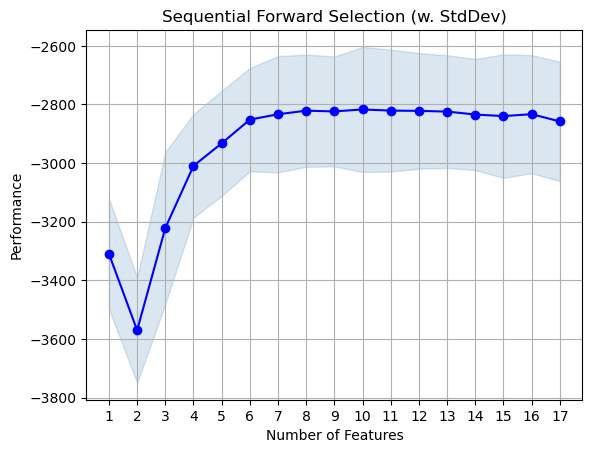

In [53]:
fig1 = plot_sfs(model.get_metric_dict(), kind='std_dev')
# plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

## Tune hyperparameters

Using leave one group out cross validation, where a group is a year.

In [54]:
parameters = {
    "n_estimators": randint(200, 500), # no. trees in the forest
    "min_samples_leaf": randint(5, 30), # min no. samples at leaf node
    "max_depth" : randint(5, 50), # max depth of each tree
    # "max_features" : uniform(0.2, 1) # max proportion of features to consider at split
    "max_leaf_nodes": randint(20, 100) # size of tree, how many end nodes
}

In [55]:
retain = ["demand"] + selected_features

In [56]:
final_features = region_dfs[region][retain]

In [57]:
final_features.head()

,demand,is_weekend,q,t2m,t2m3,w10,t2max,msdwswrf,mtpr,cdd3,cdd4
2010-01-01,-5472.341578,0,8.545424,294.798686,299.647174,5.083113,304.029629,349.269702,4.714016e-06,3.702972,3.642639
2010-01-02,-942.669393,1,6.498830,291.688480,295.290162,5.278260,297.412885,341.838323,1.253218e-07,1.210443,2.807866
2010-01-03,-3067.599531,1,6.437700,292.418152,292.968647,3.155486,298.170755,369.187339,-5.579563e-08,0.364800,0.957921
2010-01-04,-2422.636892,0,6.356869,295.950943,293.352732,1.823904,303.229501,382.836240,-5.805932e-08,0.332764,0.442270
2010-01-05,-3082.916386,0,6.562966,296.866739,295.078819,3.451809,304.371078,377.559265,9.827563e-08,0.814195,0.641284


In [58]:
train_X, test_X, train_y, test_y = fn.split(
    fn.sel_train_test(final_features, first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [59]:
# # very restricted space for testing
# parameters = {
#     "n_estimators": randint(10, 12), # no. trees in the forest
# }

In [60]:
rf = ExtraTreesRegressor()

In [61]:
logo = fn.leave_one_group_out(train_X, train_y, dem_da, str(first_train_year), str(last_train_year))

[2010 2010 2010 ... 2016 2016 2016]


In [62]:
%%time
best_params = fn.tune_hyperparameters(
    train_X,
    train_y,
    rf,
    parameters,
    logo,
    n_iter=200
)

CPU times: user 13min 30s, sys: 2.17 s, total: 13min 32s
Wall time: 13min 36s


In [63]:
best_params

{'max_depth': 29,
 'max_leaf_nodes': 99,
 'min_samples_leaf': 14,
 'n_estimators': 474}

## Finalise model

In [64]:
rf = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_depth=best_params["max_depth"],
    max_leaf_nodes=best_params["max_leaf_nodes"],
    random_state=0,
)

In [65]:
model_train, pred_train = fn.predict_forest(train_y, train_X, train_X, rf)

In [66]:
model_test, pred_test = fn.predict_forest(train_y, train_X, test_X, rf)

In [67]:
pred_train.shape

(2557,)

In [68]:
pred_test.shape

(1095,)

## Evaluate performance

In [69]:
metric_names = ["R2", "MAE", "MSE", "MAPE", "MedAE"]
metrics = [r2_score, mean_absolute_error,
           mean_squared_error, mean_absolute_percentage_error, median_absolute_error]

In [70]:
train_scores = fn.compute_scores(train_y, pred_train, metrics)

In [71]:
train_scores

[0.4134598675818758,
 2501.141119318998,
 12143897.844563192,
 1.9526798748193706,
 1798.2446741411268]

In [72]:
test_scores = fn.compute_scores(test_y, pred_test, metrics)

In [73]:
test_scores

[0.4221294115511519,
 2894.8706212174784,
 14433369.814282104,
 1.7310610905336703,
 2266.080888752361]

In [74]:
def plot_scores(train, test, metric_names):
    """
    Subplot for each metric showing score for train and test.
    """
    fig, ax = plt.subplots(2, 3, figsize=(6, 3))
    for i, a in enumerate(ax.flatten()):
        if i < len(metric_names):
            a.bar(["Train", "Test"], [train[i], test[i]])
            a.set_title(metric_names[i])
    plt.tight_layout()

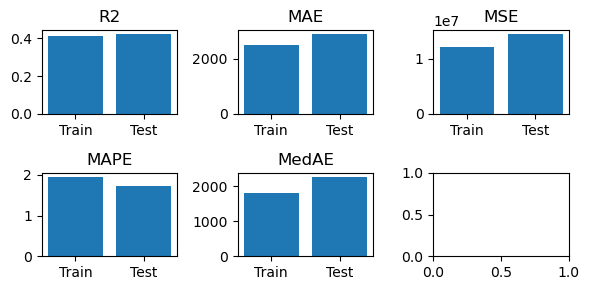

In [75]:
plot_scores(train_scores, test_scores, metric_names)

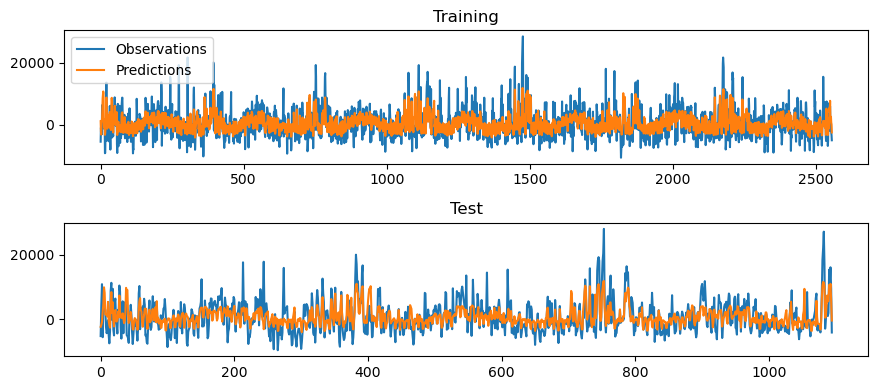

In [76]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

ax[0].plot(train_y, label="Observations")
ax[0].plot(pred_train, label="Predictions")
ax[0].legend()
ax[0].set_title("Training")

ax[1].plot(test_y)
ax[1].plot(pred_test)
ax[1].set_title("Test")

plt.tight_layout()

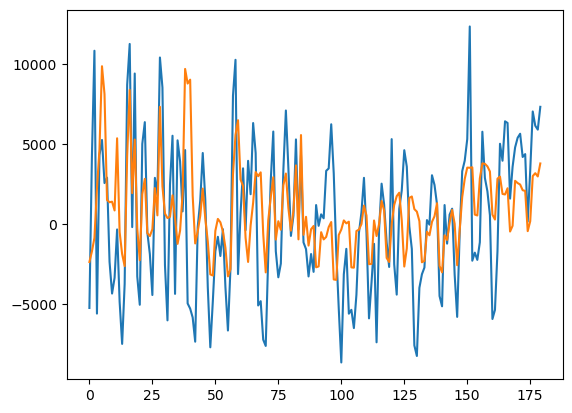

In [77]:
plt.plot(test_y[:180])
plt.plot(pred_test[:180])

## Permutation importances

Compute these on the training and test sets. Differences tell us what the model actually used to make the predictions.

In [78]:
perm_train = fn.perm_imp(
    model_train,
    train_X,
    train_y,
    n_repeats=200,
)

In [79]:
perm_test = fn.perm_imp(
    model_test,
    test_X,
    test_y,
    n_repeats=200,
)

In [80]:
perm_train

{'importances_mean': array([0.13995164, 0.01626925, 0.10572489, 0.07931434, 0.05082711,
        0.11471596, 0.02440561, 0.00493057, 0.03010124, 0.01219024]),
 'importances_std': array([0.00767917, 0.00085208, 0.00473147, 0.00350224, 0.00266331,
        0.00494296, 0.00123989, 0.00032476, 0.00184531, 0.00062019]),
 'importances': array([[0.13823381, 0.14006429, 0.13473595, ..., 0.14147323, 0.15898924,
         0.14590845],
        [0.01666628, 0.01584424, 0.01472775, ..., 0.01520337, 0.01683122,
         0.01746151],
        [0.09569864, 0.10335834, 0.11467901, ..., 0.10444087, 0.09852746,
         0.10132439],
        ...,
        [0.00420485, 0.00487804, 0.00512109, ..., 0.00493622, 0.00463681,
         0.00488321],
        [0.02698144, 0.03150382, 0.03180216, ..., 0.03053448, 0.0288593 ,
         0.03003869],
        [0.01080903, 0.01258779, 0.01293996, ..., 0.01263043, 0.01205979,
         0.01205937]])}

In [81]:
perm_test

{'importances_mean': array([0.07746051, 0.00150864, 0.11290801, 0.06718211, 0.01717762,
        0.11936247, 0.00826919, 0.00018062, 0.02204301, 0.00619968]),
 'importances_std': array([0.00894955, 0.00101213, 0.00718671, 0.00447685, 0.00376282,
        0.00779727, 0.00141239, 0.00031644, 0.00335353, 0.00105301]),
 'importances': array([[ 7.85418244e-02,  7.94944138e-02,  7.75581507e-02, ...,
          7.40198859e-02,  7.20541268e-02,  7.35219301e-02],
        [ 2.74295163e-03,  1.16625889e-03, -9.18489994e-05, ...,
          2.88342405e-03,  1.37960546e-03,  1.84245141e-03],
        [ 1.17367972e-01,  1.15038405e-01,  1.17089528e-01, ...,
          9.82815625e-02,  9.94207390e-02,  1.18130334e-01],
        ...,
        [-4.57788609e-04,  3.76797985e-04, -3.18489614e-05, ...,
          4.30664278e-04,  1.58781701e-04,  4.43500560e-04],
        [ 2.41954804e-02,  2.37801136e-02,  2.25581075e-02, ...,
          2.06896959e-02,  2.22267538e-02,  2.19887514e-02],
        [ 7.13391174e-03,  

In [82]:
fn.print_perm_imp(perm_train, selected_features)

is_weekend 0.140 +/- 0.008
t2max    0.115 +/- 0.005
t2m      0.106 +/- 0.005
t2m3     0.079 +/- 0.004
w10      0.051 +/- 0.003
cdd3     0.030 +/- 0.002
msdwswrf 0.024 +/- 0.001
q        0.016 +/- 0.001
cdd4     0.012 +/- 0.001
mtpr     0.005 +/- 0.000


In [83]:
fn.print_perm_imp(perm_test, selected_features)

t2max    0.119 +/- 0.008
t2m      0.113 +/- 0.007
is_weekend 0.077 +/- 0.009
t2m3     0.067 +/- 0.004
cdd3     0.022 +/- 0.003
w10      0.017 +/- 0.004
msdwswrf 0.008 +/- 0.001
cdd4     0.006 +/- 0.001
